# Network Intrusion Detection Model 


## 1. Introduction 

Communication systems are an integral part of our daily life, with computer networks serving as a business data processing, education, collaboration, data acquisition and entertainment. The current computer network stack was designed to prioritise transparency and user-friendliness, which as led to communication protocol susceptible to attacks (Belavagi and Muniyal, 2016) . Therefore, a continuous monitoring is essential to protect the user’s privacy and potential damage to the function and infrastructure of a whole network. Modern Intrusion Detection Systems (IDS), leverage machine learning techniques to build predictive models (i.e. a classifier) capable to analyse and process large volumes of web servers network traffic using specific attributes to distinguish between bad connections, known as intrusions or attacks, and good normal connections (Dhanabal and Shantharajah, 2015). 

## 2. Methodology 
The aim of this report is to build an intrusion detection system and evaluate the performance of two machine learning models; decision trees and support vector machine for binary classification to recognise network traffic as either “normal” or “malicious” given a data point based on the NSL-KDD dataset. 

The steps involved in building the IDS are as follows (Ingre, Yadav and Soni, 2017):
1. The first step is selecting the NSL-KDD dataset from its dataset repository. In pre-processing step all the categorical data which are in textual form are converted to numerical form.
2. The pre-processed data is then divided as testing data and training data. The models are then built using Decision Trees and Support Vector Machines algorithms.
3. These models are then used for predicting the labels of the test data. Actual labels and predicted labels are compared. 
4. The True Positive Rate (TRP) and False Positive Rate (FPR) values are computed. Based on these parameters performance of the models is compared.

## 3. Data Preparation

Data preparation involves cleaning and transforming the raw data before pre-processing and analysis. To prepare the NSL-KDD dataset, first the connections are initially categorised into normal and anomaly classes based on "labels" column. Then attacks are then grouped into four main categories (Pai, Devidas and Adesh, 2021): 

- Denial of Service (DoS): attack over usage of the bandwidth of network resources making the system unable to handle legitimate requests - e.g. syn flooding. Relevant features: "source bytes" and "percentage of packet with errors"
- Probing: attack for surveillance with the objective to gain information about the victim - e.g. port scanning. Relevant features: "duration of connection" and "source bytes"
- U2R: privilege attack to unauthorised access to local super user (root), where an attacker uses a normal account to login into a victim system and tries to gain root privilages by exploiting the victim's resources - e.g buffer overflow. Relevant features: "number of file creations" and "number of shell prompts invoked".
- R2L: unauthorised access from a remote machine, the threat actor intrudes into a remote machine and gains local access of the victim's machine - e.g password brute force. Relevant features: "duration of connection" and "service requested". 

Following this step, all of the categories are indexed and new column is added ("binary_label") to simplify the work with the clustered data. 

**Importing Essential Modules:**

In [26]:
# Import necessary libraries
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import itertools
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC

### NSL-KDD dataset overview

The NSL-KDD dataset (Tavallaee et al., 2009) builds upon the KDD99 dataset. Due to the significant number of improvements, including:

1.	Removed redundant records to ensure unbiased classifier results.
2.	Sufficient records in train and test to enable reasonable experiments on the complete set.
3.	Record selection from difficult level groups is inversely proportional to the original KDD data percentage.

The NSL-KDD dataset was selected for training and testing the IDS. In each record of the dataset there are 41 attributes illustrating different features of the flow, as shown below. And a label ("attack") assigned to each other either as an attack type or as normal. Table 1, details the type of information of all 41 attributes available in the NSL-KDD dataset.

In [27]:
# define column names to the dataset
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "difficulty"]




|     Type        |     Features |
|-----------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     Nominal     |     Protocol_type(2), Service(3), Flag|
|     Binary      |     Land(7), logged_in(12), root_shell(14), su_attempted(15),   is_host_login(21), Is_guest_login(22)|
|     Umeric      |     Duration(1), src_bytes(5), dst_bytes(6), wrong_fragment(8),   urgent(9), hot(10), num_failed_logins(11), num_compromised(13), num_root(16),   num_file_creations(17), num_shells(18), num_access_files(19), num_outbound_cmds(20),   count(23) srv_count(24), serror_rate(25), srv_serror_rate(26),   rerror_rate(27), srv_rerror_rate(28), same_srv_rate(29) diff_srv_rate(30), srv_diff_host_rate(31),   dst_host_count(32), dst_host_srv_count(33), dst_host_same_srv_rate(34), dst_host_diff_srv_rate(35),   dst_host_same_src_port_rate(36), dst_host_srv_diff_host_rate(37), dst_host_serror_rate(38),   dst_host_srv_serror_rate(39), dst_host_rerror_rate(40), dst_host_srv_rerror_rate(41)    |

*Table 1 - Attribute Value Type*

**Loading NSL-KDD dataset**

In [28]:
train = pd.read_csv('/workspaces/WM3B2-Data-Science/CW1/KDD-Data/KDDTrain+.csv', sep=',', header=None, names=col_names)
test = pd.read_csv('/workspaces/WM3B2-Data-Science/CW1/KDD-Data/KDDTest+.csv', sep=',', header=None, names=col_names)

In [29]:
# train.head()

print('Dimensions of the Training set:', train.shape)
print('Dimensions of the Test set:', test.shape)

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


**View of the Training Dataset**

Below shows a preview of the training data set which will be used to train the IDS

In [30]:
train.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## 4. Data Pre-Processing

Data preprocessing is an essential part for building the IDS, as the quality of data and the useful information that can be extracted from the dataset directly impacts the ability of the IDS to learn. Data pre-processing handles all the null values, standarisation and categorical values of the dataset. This is because data that is incomplete, inconsistent and without a certain behavior is likely to contain errors (Dash, 2021). 

To prevent this, the following steps are taken:
1. Encoding categorical features:  all of the categorical features in the NSL-KDD dataset; "Protocol Type", "service", and "Flag" are encoded using LabelEncoder and one-hot encoding (one-of-k) to convert nominal values into binary values. 
2. Creating a binary label column: A "binary_label" is added to classify all network instances as either "normal" or "malicious". 
3. Dropping unnecessary columns: The "attack" column is dropped as it is replaced by the binary label.

**Encoding Categorical Values**

In [31]:
def preprocess_dataset(dataset):
    categorical_columns = ["protocol_type", "service", "flag"] # defines categorical features
    
    dataset['binary_label'] = dataset['attack'].apply(lambda x: 'malicious' if x != 'normal' else 'normal') # creates a new column with binary labels
    dataset = dataset.drop(['attack'], axis=1) # drops the original attack column
    
    # encoding categorical features into numerical data
    le = LabelEncoder()
    for col in categorical_columns:
        dataset[col] = le.fit_transform(dataset[col])
    
    return dataset

# call functions on train and test data
train = preprocess_dataset(train)
test = preprocess_dataset(test)

**Data Splitting**

The pre-processed dataset is then divided into training and testing sets. This splitting ensures that the models are trained on one subset and evaluated on another, providing a realistic assessment of their generalisation capabilities.


In [32]:
# function to split the dataset into features and labels
def split_dataset(dataset): 
    X = dataset.iloc[:, :-1] # all rows, all the features and no labels
    y = dataset.iloc[:, -1]  # all rows, label only
    return X, y

X_train, y_train = split_dataset(train)
X_test, y_test = split_dataset(test)

In [33]:
train['target'] = train.iloc[:,42].apply(lambda x: 0 if x == 'normal' else 1)

test['target'] = test.iloc[:,42].apply(lambda x: 0 if x == 'normal' else 1)

data = train['target'].value_counts()
lab = ['normal','malicious']
data

target
0    67343
1    58630
Name: count, dtype: int64

## 5. Machine Learning Models Analysis

This report evaluates the following two machine learning classification models based on their suitability for the problem:

- Decision Trees: This technique divides the classification problem into sub-problems. It builds a decision tree which in turn is used to develop a model that is used for the classification purpose using the "DecisionTreeClassifer" feature. This technique is chosen based on the model's ability to handle both numerical and categorical data, providing insights into feature importance. The three structure is visualised, offering transparency into decision-making process.

- Support Vector Machine (SVM): This technique classifies data into two classes over a hyper plane. Each data item is plot as a point in a n-dimensional space where n represents the number of features with the value of each feature being the values of a particular coordinate. SVM is chosen for its effectiveness in high-dimensional spaces and its ability to handle multiple feature sets. 

### Model Training & Evaluation

The code below showcases how the two models are trained using the KDD-Train+.txt training dataset, and evaluated using the following metrics:
- Accuracy: This metric provides an overall measure of the model's correctness.
- Precision, Recall, and F1-score; these are class-specific metrics which offer insights into the models ability to correctly classify "normal" or "malicious" instances.
- ROC Curves and AUC Values: by analysing receiver operating characteristic (ROC) curves and calculating area under the curve (AUC) values, a deeper understanding of the models' discriminatory ability.

**Malicious Vs Normal Traffic Ratio**

The following graph, visualises the ratio between "normal" and "malicious" network traffic.

In [34]:
# Rendering Pie Charts

def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette('flare')
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                        colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs 

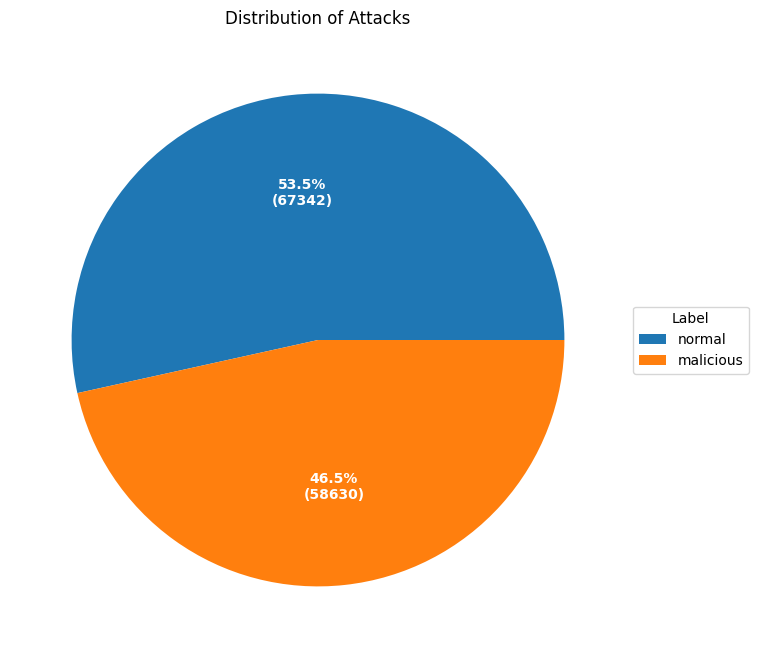

In [35]:
# Plotting Pie Chart

fig, axis = plt.subplots(figsize=(8,8), subplot_kw=dict(aspect="equal"))
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = axis.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
axis.legend(wedges, lab,
          title="Label",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

axis.set_title("Distribution of Attacks")

plt.setp(autotexts, size=10, weight="bold")
plt.show()

In [36]:
#OneHotEncoding
categorical = [1,2,3]
encoder = LabelEncoder()
for col in categorical:
    train.iloc[:,col] = pd.Series(encoder.fit_transform(train.iloc[:,col]))
    test.iloc[:,col] = pd.Series(encoder.transform(test.iloc[:,col]))

In [37]:
#now the part where the model is trained and tested

clf = DecisionTreeClassifier(random_state=1234) #creates a decision tree classifier

#train the model
model = clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

#score accuracy
print("Accuracy of model:", clf.score(X_test, y_test)*100)



# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy of model: 85.42849538679916
              precision    recall  f1-score   support

   malicious       0.98      0.76      0.86     12833
      normal       0.76      0.98      0.85      9711

    accuracy                           0.85     22544
   macro avg       0.87      0.87      0.85     22544
weighted avg       0.88      0.85      0.85     22544



In [38]:
train = pd.concat([train,test],axis=0)

X = train.drop(columns='target',axis=1)
y = train.target

for col in X.columns:
    if X[col].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(X[col].values))
        X[col] = lbl.transform(list(X[col].values))

scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,random_state=10)

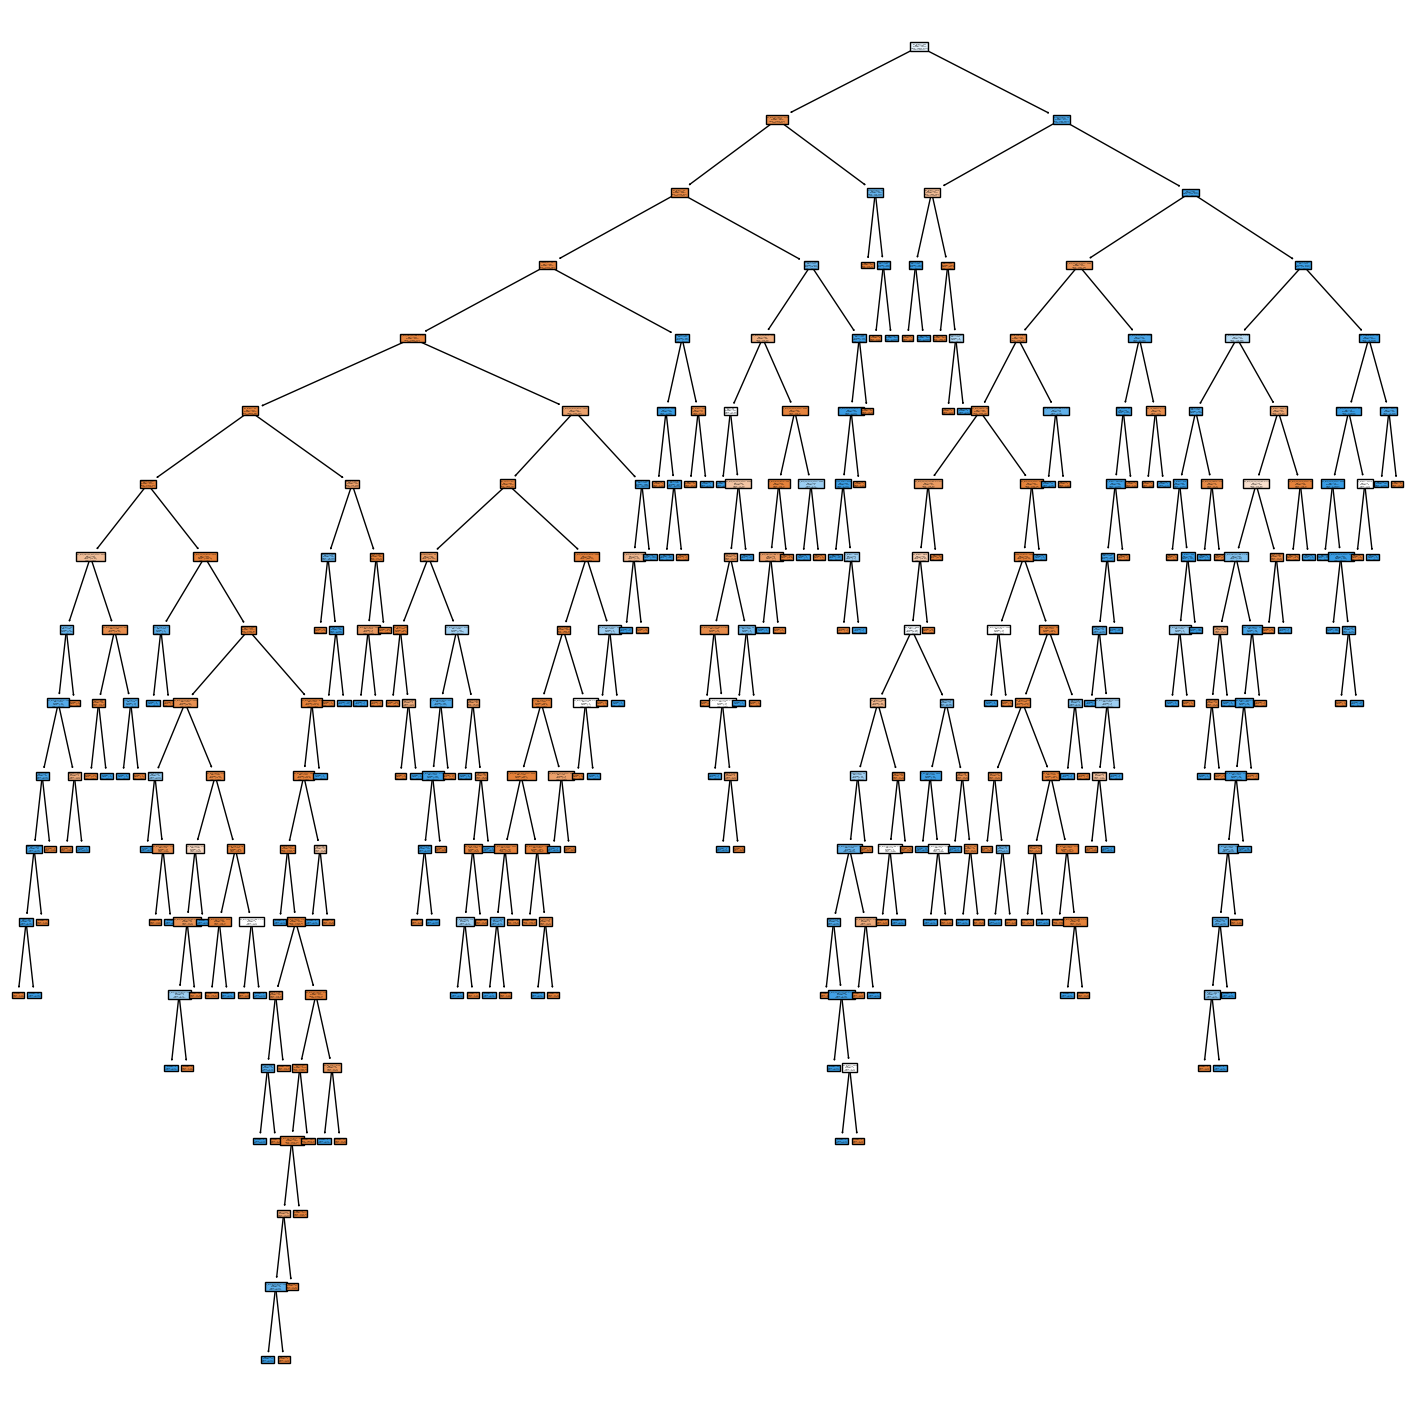

In [39]:
fig, ax = plt.subplots(figsize=(18, 18))  # Create a new figure with a custom size


tree.plot_tree(model, 
                   feature_names = list(X.columns), 
                   class_names = ['normal', 'malicious'],
                   filled = True,
                   ax=ax);  # Create the plot;

plt.show()  # Display the figure

Text(0, 0.5, 'Importance')

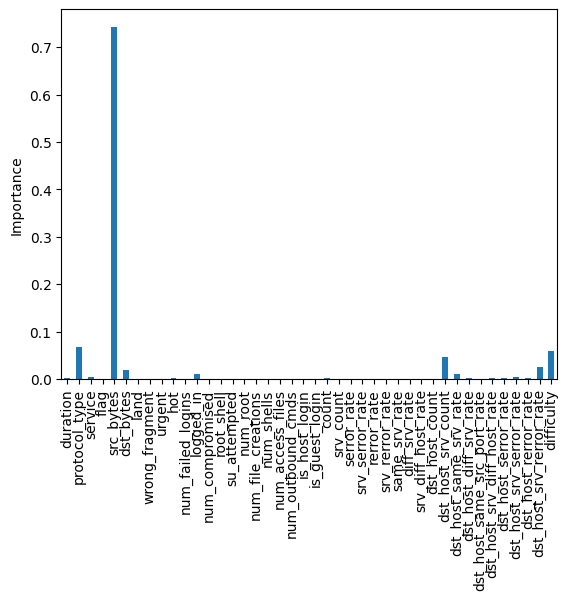

In [40]:
importance = model.feature_importances_
feature_importance = pd.Series(importance, index=X.columns[:-1])  # Exclude the last column
feature_importance.plot(kind='bar')
plt.ylabel('Importance')


**Support Vector Machine (SVM)**

In [41]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

print("Train score: ",svm.score(X_train, y_train))

pred_svc = svm.predict(X_test)
print('Test score:',svm.score(X_test, y_test))

print("Classification report: ",classification_report(pred_svc,y_test))

print("Average weighted precision: ",precision_score(y_test,pred_svc))
print("Average weighted recall: ",recall_score(y_test,pred_svc))
print("Average weighted f1 score: ",f1_score(y_test,pred_svc))

Train score:  0.9999730668749495
Test score: 0.9997306760032318
Classification report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     19240
           1       1.00      1.00      1.00     17890

    accuracy                           1.00     37130
   macro avg       1.00      1.00      1.00     37130
weighted avg       1.00      1.00      1.00     37130

Average weighted precision:  1.0
Average weighted recall:  0.9994413407821229
Average weighted f1 score:  0.9997205923442302


## References:
Reference listBelavagi, M.C. and Muniyal, B. (2016). Performance Evaluation of Supervised Machine Learning Algorithms for Intrusion Detection. Procedia Computer Science, [online] 89, pp.117–123. doi:https://doi.org/10.1016/j.procs.2016.06.016.

Dash, J. (2021). Network Intrusion detection system. [online] Analytics Vidhya. Available at: https://medium.com/analytics-vidhya/network-intrusion-detection-system-4bab3e5baccb.

Dhanabal, L. and Shantharajah, S. (2015). A Study on NSL-KDD Dataset for Intrusion Detection System Based on Classification Algorithms. International Journal of Advanced Research in Computer and Communication Engineering, [online] 4. doi:https://doi.org/10.17148/IJARCCE.2015.4696.

Ingre, B., Yadav, A. and Soni, A.K. (2017). Decision Tree Based Intrusion Detection System for NSL-KDD Dataset. Information and Communication Technology for Intelligent Systems (ICTIS 2017) - Volume 2, pp.207–218. doi:https://doi.org/10.1007/978-3-319-63645-0_23.

Pai, V., Devidas, C. and Adesh, N.D. (2021). Comparative analysis of Machine Learning algorithms for Intrusion Detection. IOP Conference Series: Materials Science and Engineering, 1013(1), p.012038. doi:https://doi.org/10.1088/1757-899x/1013/1/012038.Tavallaee, M., Bagheri, E., Lu, W. and Ghorbani, A.A. (2009).

 A detailed analysis of the KDD CUP 99 data set. 2009 IEEE Symposium on Computational Intelligence for Security and Defense Applications. [online] doi:https://doi.org/10.1109/cisda.2009.5356528.